
### For more information, see https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html

In [1]:

#!pip install opencv-python==3.4.2.16

#!pip install opencv-contrib-python==3.4.2.16

In [2]:
%matplotlib inline

from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse

from matplotlib import pyplot as plt
print("OpenCV Version : %s " % cv.__version__)

OpenCV Version : 3.4.2 


In [3]:
img1 = cv.imread('box.png', cv.IMREAD_GRAYSCALE)
print(img1.shape)

(223, 324)


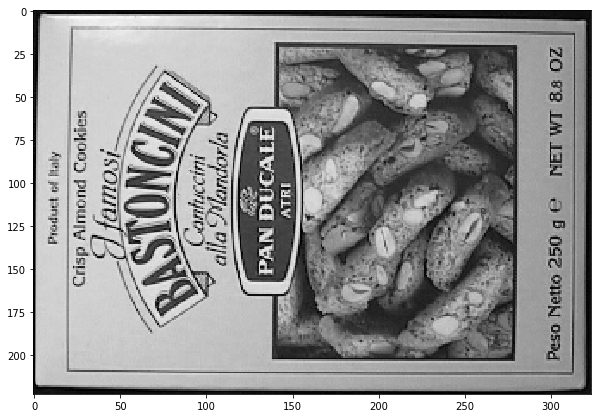

In [4]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img1,cmap='gray')
plt.show()

In [5]:
img2 = cv.imread('box_in_scene.png', cv.IMREAD_GRAYSCALE)
print(img2.shape)

(384, 512)


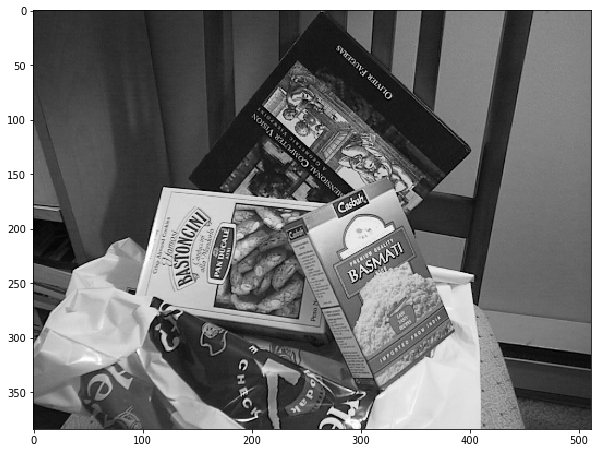

In [6]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img2,cmap='gray')
plt.show()

In [7]:
#-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
minHessian = 400
detector = cv.xfeatures2d_SURF.create(hessianThreshold=minHessian)
keypoints1, descriptors1 = detector.detectAndCompute(img1, None)
keypoints2, descriptors2 = detector.detectAndCompute(img2, None)


In [8]:
print(len(keypoints1)) #query image
print(len(keypoints2)) #train image

786
1040


In [9]:
print(descriptors1.shape)
print(descriptors2.shape)


(786, 64)
(1040, 64)


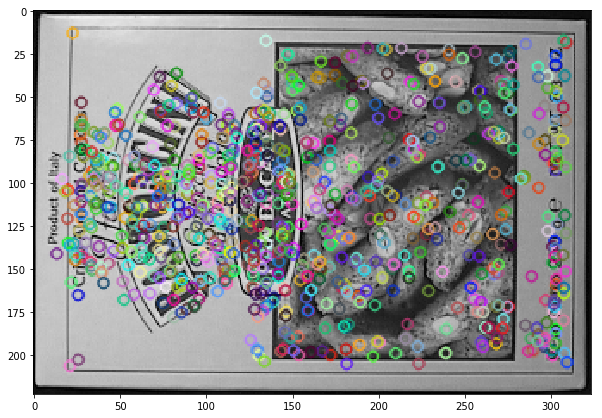

In [10]:
#-- Draw keypoints
img1b=img1
img_keypoints = np.empty((img1b.shape[0], img1b.shape[1], 3), dtype=np.uint8)
cv.drawKeypoints(img1b, keypoints1, img_keypoints)
#-- Show detected (drawn) keypoints
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_keypoints)


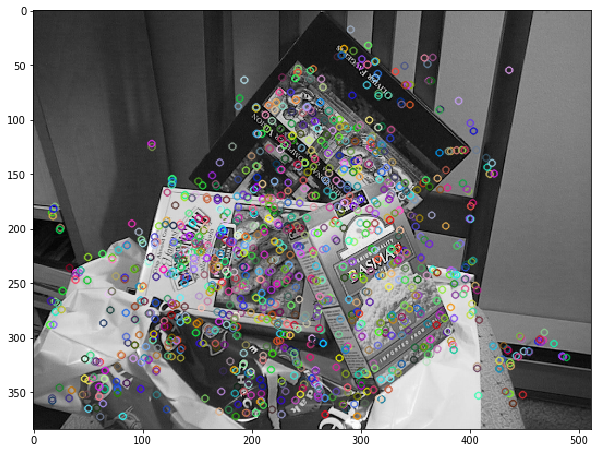

In [11]:
#-- Draw keypoints
img2b=img2
img_keypoints = np.empty((img2b.shape[0], img2b.shape[1], 3), dtype=np.uint8)
cv.drawKeypoints(img2b, keypoints2, img_keypoints)
#-- Show detected (drawn) keypoints
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_keypoints)

In [12]:
#-- Step 2: Matching descriptor vectors with a FLANN based matcher
# Since SURF is a floating-point descriptor NORM_L2 is used
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)


In [13]:
help(matcher.knnMatch)

Help on built-in function knnMatch:

knnMatch(...) method of cv2.DescriptorMatcher instance
    knnMatch(queryDescriptors, trainDescriptors, k[, mask[, compactResult]]) -> matches
    .   @brief Finds the k best matches for each descriptor from a query set.
    .   
    .   @param queryDescriptors Query set of descriptors.
    .   @param trainDescriptors Train set of descriptors. This set is not added to the train descriptors
    .   collection stored in the class object.
    .   @param mask Mask specifying permissible matches between an input query and train matrices of
    .   descriptors.
    .   @param matches Matches. Each matches[i] is k or less matches for the same query descriptor.
    .   @param k Count of best matches found per each query descriptor or less if a query descriptor has
    .   less than k possible matches in total.
    .   @param compactResult Parameter used when the mask (or masks) is not empty. If compactResult is
    .   false, the matches vector has the same

In [23]:
#Find 2 matches for each of the query points
knn_matches = matcher.knnMatch(descriptors1, descriptors2, 2) 
# We can only use 2-nearest neighbour, because of the Lowe ratio test that we will use in the next cell
print(len(knn_matches))

786


To filter the matches, Lowe proposed to use a distance ratio test to try to eliminate false matches. 

The distance ratio between the two nearest matches of a considered keypoint is computed and it is a good match when this value is below a thresold. Indeed, this ratio allows helping to discriminate between ambiguous matches (distance ratio between the two nearest neighbors is close to one) and well discriminated matches. 

You find the 2 nearest neighbors of a query feature from the training feature set. Let d1 be the distance to the nearest neighbor and d2 be the distance to the next one. In order to accept the nearest neighbor as a “match”, d1/d2 ratio should be smaller than a given threshold (0.7 in th example below). 

The motivation behind this test is that we expect a good match to be much closer to the query feature than the second best match. If both features are similarly close to the query (that is the ratio is around 1), then we cannot decide which one is really the best one.

In [24]:
#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.7
good_matches = []
for m,n in knn_matches: #each of the knn_matches contains 2 matches: m,n
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)
print(len(good_matches))


62


In [25]:
#-- Draw matches
img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)


In [26]:
results=cv.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


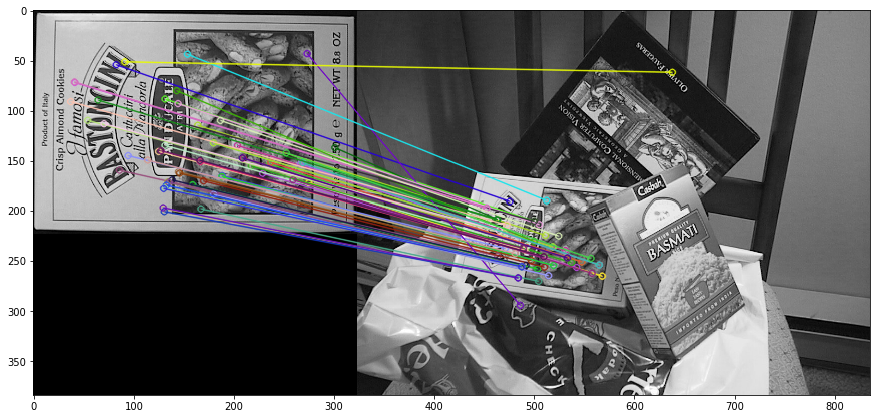

In [27]:
#-- Show detected matches
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_matches)